# Scale-free property of cointegrated pairs

For small enough significantly cointegrated set of stock pairs the resulting network exhibits scale-free property (just like MST and PMFG from correlations), and for larger number of pairs small-world property. On average, if the portfolio of pairs is traded with all significantly cointegrated pairs 10% of the stocks with the highest degree (number of times it is in a pair) will have about 30% exposure, 20% of stocks will have 50% exposure, 40% of stocks will have 70% exposure and 70% of the stocks will have 90% of the exposure in the portfolio. This phenomenon holds true regardless of the breakdown (none, sector, industry or any other).

Although the exposure is spread uniformly throughout the pairs, it does not result in a uniform exposure throughout individual companies. High degree companies are overcrowding the portfolio, thus their divergence is riskier for the strategy, and low degree companies are under represented.

Putting a limit on the number of times a company can be part of a pair might help to reduce the volatility of the strategy, as it is less exposed to individual company movements of the high degree stocks, and exposures are spread evenly both through pairs and individual stocks.

In [233]:
from datetime import datetime, date
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar

import math
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from arch.unitroot import ADF as archADF
from matplotlib import gridspec

import time
import itertools

from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

from pylr2 import regress2
from IPython.display import clear_output

from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
from collections import Counter
from scipy.stats import rankdata
import matplotlib.patches as mpatches

import networkx as nx
import matplotlib

In [234]:
###Parameters
stock_index = 'SNP'          #SNP, NIKKEI, BOVESPA
formation_year = 2011        #2010-2020 - when we take the components of the index
brkdwn = 'None'          #None, Sector, Industry
formation_period = 12        #in months, integers only
trading_period = 6          #in months, integers only

#Getting data
comp_stats=pd.read_csv("{}_comp_stats.csv".format(stock_index),index_col=0)
price_data=pd.read_csv("{}_prices2005-2021.csv".format(stock_index),index_col=0)
tickers=pd.read_csv("{}_tickers_2010-2020.csv".format(stock_index),index_col=0)

In [235]:
#Defining formation and trading periods
def create_dates(formation_date):
    trading_start=str(pd.Timestamp(formation_date).date())
    formation_start =str((pd.Timestamp(formation_date)-pd.DateOffset(months=formation_period)).date())
    endD=str((pd.Timestamp(formation_date)+pd.DateOffset(months=trading_period)).date())

    formation_end = str((pd.Timestamp(trading_start)-pd.DateOffset(days=1)).date())
    trading_end = str((pd.Timestamp(endD)-pd.DateOffset(days=1)).date())
    return formation_start, formation_end, trading_start, trading_end

formation_date = '{}-01-01'.format(formation_year)
formation_year = int(formation_date[0:4])
fP1, fP2, tP1, tP2 = create_dates(formation_date)

In [236]:
def clean_data(fP1, tP2, formation_year, stock_index):
    #Only include tickers that are in the stock index for the year and we have data for it
    valid_tickers=(set(price_data[fP1:tP2].columns)) & (set(tickers.loc[formation_year][stock_index]))

    #Drop ticker that miss >20% of their price series, forward fill the rest,
    #then drop the tickers that still has missing values,
    #those can only have it at the start of their price series, would cause problems later in testing
    clean_prices=price_data[fP1:tP2][valid_tickers]
    clean_prices=clean_prices.dropna(axis=1,thresh=round(clean_prices.shape[0]*0.8))
    clean_prices=clean_prices.fillna(method="ffill")
    if pd.isnull(clean_prices.iloc[0]).all():
        clean_prices=clean_prices.drop(clean_prices.index[0], axis=0)
    clean_prices=clean_prices.dropna(axis=1)
    
    return clean_prices

clean_prices = clean_data(fP1, tP2, formation_year, stock_index)

In [237]:
corr_mat = clean_prices[fP1:fP2].pct_change().dropna().corr()
Gcorr = nx.from_numpy_matrix(abs(corr_mat-1).to_numpy())
stocks = clean_prices.columns.values
Gcorr = nx.relabel_nodes(Gcorr,lambda x: stocks[x])
mst = nx.algorithms.tree.minimum_spanning_edges(Gcorr, algorithm="prim", data=False)
Gmst = nx.Graph(list(mst))

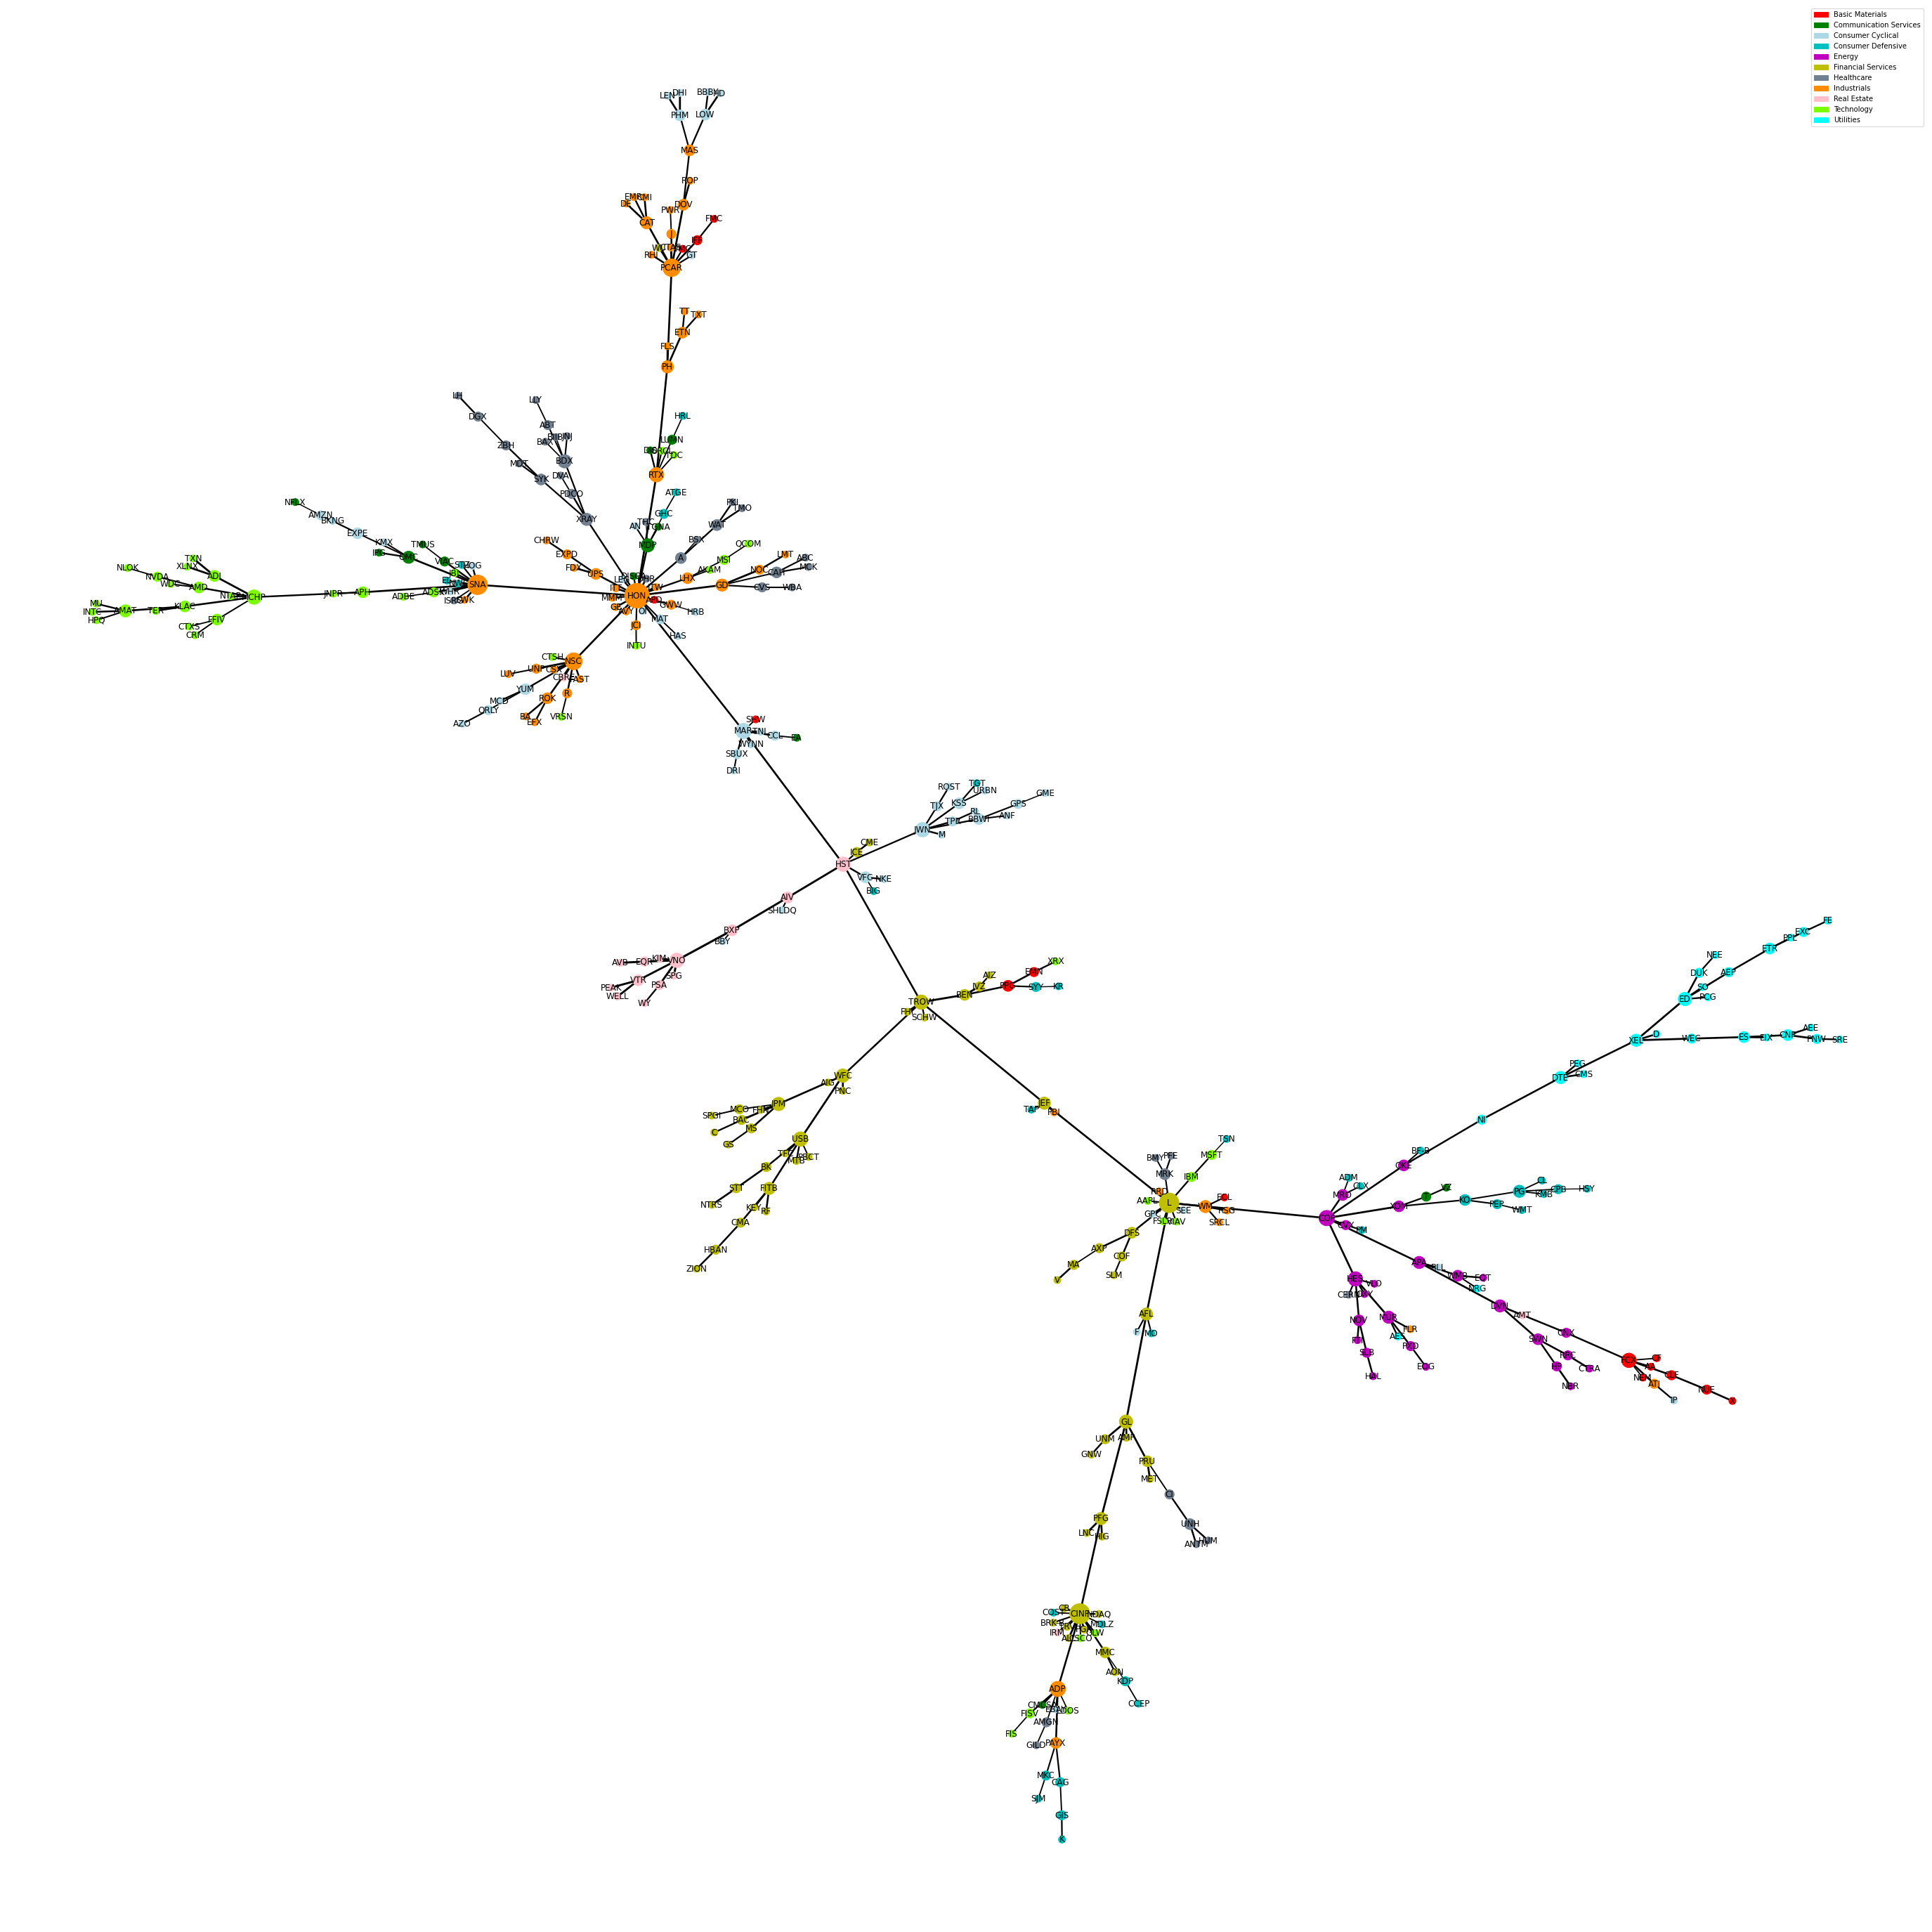

In [238]:
colors = ['r','g','lightblue','c','m','y','slategrey','darkorange','pink','lawngreen','aqua']
cmap3 = LinearSegmentedColormap.from_list('rets', ['#02055A','#0000FF','#FFFF00','#FF0000','#990000','#330000'])
cmap3 = plt.get_cmap('jet')
corr_c_list = [matplotlib.colors.to_hex(cmap3(corr_mat.loc[edge[0],edge[1]])) for edge in list(Gmst.edges)]

plt.figure(figsize=(38,38))
degree = dict(nx.degree(Gmst))
cmap = matplotlib.colors.ListedColormap(['r','g','lightblue','c','m','y','slategrey','darkorange','pink','lawngreen','aqua'])
pos_g = nx.spring_layout(Gmst, k = 0.02, iterations = 500, seed = 33)
nx.draw(Gmst, pos = pos_g, with_labels=True, nodelist=degree.keys(), node_size=[v**0.8*100 for v in degree.values()],
        node_color=pd.Categorical(comp_stats.loc[degree.keys()].Sector).codes, cmap=cmap,
        width=[(corr_mat.loc[edge[0],edge[1]]*2.5**2.5)/3 for edge in list(Gmst.edges)])

#nx.draw_networkx_edge_labels(Gmst, pos = pos_g,edge_labels=edge_weights,font_color='black',font_size = 9);
#plt.tight_layout()
#plt.show()


plt.legend(handles=[mpatches.Patch(color=f'{colors[i]}', label=f'{comp_stats.loc[degree.keys()].Sector[np.where(pd.Categorical(comp_stats.loc[degree.keys()].Sector).codes == i)[0][0]]}') for i in range(11)]);

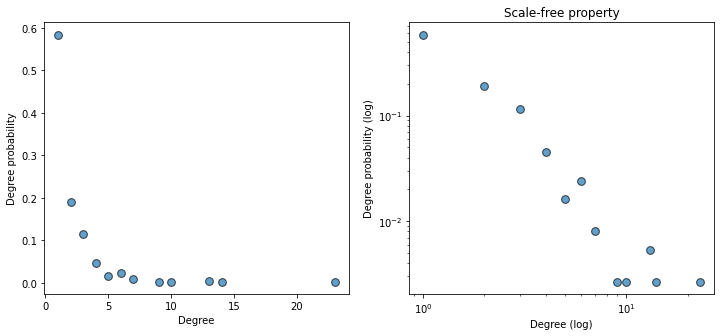

In [239]:
degree_count = pd.Series(dict(Gmst.degree).values(),index=dict(Gmst.degree).keys(),name='Degree')

degreeProb = pd.Series(Counter(degree_count).values(),index=Counter(degree_count).keys())/sum(Counter(degree_count).values())
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(degreeProb.index, degreeProb.values, s=60, alpha=0.7, edgecolors="k")
plt.xlabel('Degree')
plt.ylabel('Degree probability')
plt.subplot(1,2,2)

plt.scatter(degreeProb.index, degreeProb.values, s=60, alpha=0.7, edgecolors="k")
plt.title('Scale-free property')
plt.xlabel('Degree (log)')
plt.ylabel('Degree probability (log)')
plt.yscale("log")
plt.xscale("log");

In [240]:
def get_stationary_tickers(clean_prices):
    stat_tics = []
    for i in clean_prices:
        if archADF(clean_prices[fP1:fP2][i]).pvalue < 0.05:
            stat_tics.append(i)
    return stat_tics

stat_tics = get_stationary_tickers(clean_prices)
#Remove stationary price series from the dataset
clean_prices=clean_prices.drop(stat_tics, axis=1)

In [241]:
def get_ticker_brkdwn(brkdwn):
    brkdwn_list=[]
    if brkdwn == 'None':
        brkdwn_list = (list(set(clean_prices)),[])
    else:
        for i in comp_stats[brkdwn].unique():
            brkdwn_list.append(list(comp_stats.loc[clean_prices.columns].query('{}=="{}"'.format(brkdwn,i)).index))
    return brkdwn_list

brkdwn_list = get_ticker_brkdwn(brkdwn)

In [242]:
def get_coint_pairs_ADF(brkdwn_list,show_progress=False):
    total = 0
    noPosP = 0
    for i in range(len(brkdwn_list)):
        noPosP += (len(list(itertools.combinations(brkdwn_list[i],2))))

    allPosPairs = pd.DataFrame(columns=['Pair','ADF','LS'],index=np.arange(noPosP))

    for i in range(len(brkdwn_list)):
        for pair in list(itertools.combinations(brkdwn_list[i],2)):
            allPosPairs.iloc[total,0] = pair
            spread, beta = RMAspr(list(pair))
            
            
            allPosPairs.iloc[total,1] = archADF(spread, trend='c', method='aic').pvalue
            allPosPairs.iloc[total,2] = 1 if beta>0 else 0
            total += 1
            if show_progress:
                if total % 100 == 0:
                    clear_output(wait=True)
                    print(total, '/', noPosP)
    return allPosPairs
allPosPairs = get_coint_pairs_ADF(brkdwn_list, True)

64600 / 64620


In [243]:
pairsADF = list((allPosPairs.query('LS==1').sort_values(by='ADF')).head(clean_prices.shape[1]-len(stat_tics)-1).Pair)
print(allPosPairs.shape[0])
print(len(pairsADF))

64620
346


In [244]:
def RMAspr(pair):
    pair = list(pair)
    results = regress2(clean_prices[pair[0]][fP1:fP2], clean_prices[pair[1]][fP1:fP2], _method_type_2="reduced major axis")
    spr = clean_prices[pair][fP1:fP2]@np.array([1,-1/results['slope']])

    return spr , results['slope']

def pos_func(nSpr, entries, weights, stoploss=np.nan, block=False, push=True):
    posit = pd.Series(np.nan, index=nSpr[tP1:tP2].index, name='Pos')
    posit.iloc[0] = 0
    posit[nSpr*nSpr.shift(1) < 0] = 0
    for i in np.arange(len(entries)):
        posit[(nSpr+entries[i])*(nSpr.shift(1)+entries[i])< 0] = weights[i]
        posit[(nSpr-entries[i])*(nSpr.shift(1)-entries[i])< 0] = -weights[i]
    if not np.isnan(stoploss):
        posit[(nSpr+float(stoploss))*(nSpr.shift(1)+float(stoploss))< 0] = 0
        posit[(nSpr-float(stoploss))*(nSpr.shift(1)-float(stoploss))< 0] = 0
    else:
        block=False
    posit.ffill(inplace=True)
    
    if len(entries) > 1:
        for i in range(1,len(posit)):
            if abs(posit).values[i]>abs(posit).values[i-1] or abs(posit).values[i]==0 or \
            posit.values[i]*posit.values[i-1]<0:
                posit.values[i]=posit.values[i].copy()
            else:
                posit.values[i]=posit.values[i-1].copy()
    if block:
        if not nSpr[(nSpr>float(stoploss)) | (nSpr<-float(stoploss))].empty:
            posit[nSpr[(nSpr>float(stoploss)) | (nSpr<-float(stoploss))].index[0]:] = 0
    if push:
        posit=posit.shift(1)
        posit.iloc[0]=0
    return posit

def equity_curve(positions, df, weiV, initial_cash=100, leverage=2,shorting_cost=0.01,commission=0.0008,market_impact=0.002):
    trades=positions.diff()
    trades.iloc[0]=positions[0]-0
    cash=pd.Series(data=np.nan,index=positions.index,name='Cash')
    portfolio=pd.Series(data=np.nan,index=positions.index,name='Portfolio')
    shares=pd.Series(data=np.nan,index=positions.index,name='Shares')
    transaction_costs=pd.Series(data=np.nan,index=positions.index,name='Tc')
    
    portfolio.iloc[0]=initial_cash
    shares.iloc[0]=leverage*portfolio.iloc[0]/abs(df*weiV).sum(axis=1)[0]
    cash.iloc[0]=portfolio.iloc[0]-(shares[0]*df.iloc[0]*weiV*trades[0]).sum()
    transaction_costs.iloc[0]=abs(shares[0]*weiV*df.iloc[0]*trades[0]).sum()*(commission+market_impact)+(shares[0]*positions[0]*df.iloc[0]*weiV).combine(0, min).sum()*(-shorting_cost/252)

    for i in range(1,len(cash)):
        if ~(((positions[i]>0) & (trades[i]>0)) | ((positions[i]<0) & (trades[i]<0))):
            shares.iloc[i]=shares.iloc[i-1]
        else:
            shares.iloc[i]=leverage*portfolio.iloc[i-1]/abs(df*weiV).sum(axis=1)[i]
        transaction_costs.iloc[i]=abs(shares[i]*weiV*df.iloc[i]*trades[i]).sum()*(commission+market_impact)+(shares[i]*positions[i]*df.iloc[i]*weiV).combine(0, min).sum()*(-shorting_cost/252)
        cash.iloc[i]=cash.iloc[i-1]-(shares[i]*df.iloc[i]*weiV*trades[i]).sum()-transaction_costs.iloc[i]
        portfolio.iloc[i]=cash.iloc[i]+(shares[i]*positions[i]*df.iloc[i]*weiV).sum()
        
    return portfolio

In [245]:
portfolios = {}

for c, pair in enumerate(pairsADF):
    pair = list(pair)
    results = regress2(clean_prices[pair[0]][fP1:fP2], clean_prices[pair[1]][fP1:fP2], _method_type_2="reduced major axis")
    spr = clean_prices[pair][fP1:tP2]@np.array([1,-1/results['slope']])
    spr_mean = spr[fP1:fP2].mean()
    spr_std = spr[fP1:fP2].std()
    norm_spr = (spr-spr_mean)/spr_std


    positions = pos_func(norm_spr[tP1:tP2],entries=np.array([2]),weights=np.array([1.0]),block=True,stoploss=5)
    port = equity_curve(positions, clean_prices[list(pair)][tP1:tP2], np.array([1,-1/results['slope']]),shorting_cost=0.0,commission=0.0,market_impact=0.0)
    portfolios[tuple(pair)] = port
    
    if c%10==0:
        clear_output(wait=True)
        print(c,'/',len(pairsADF))

340 / 346


In [246]:
edge_data = pd.DataFrame(index=range(len(pairsADF)),columns=['leg1','leg2','Ret'])
for c, i in enumerate(portfolios):
    edge_data.loc[c, 'leg1'] = i[0]
    edge_data.loc[c, 'leg2'] = i[1]
    edge_data.loc[c, 'Ret'] = portfolios[i][-1]

In [247]:
custom_cmap = LinearSegmentedColormap.from_list('rets', ['#DC143C', '#FFFFFF', '#228B22'])
bounds = np.arange(80, 120)
norm = BoundaryNorm(bounds, custom_cmap.N)

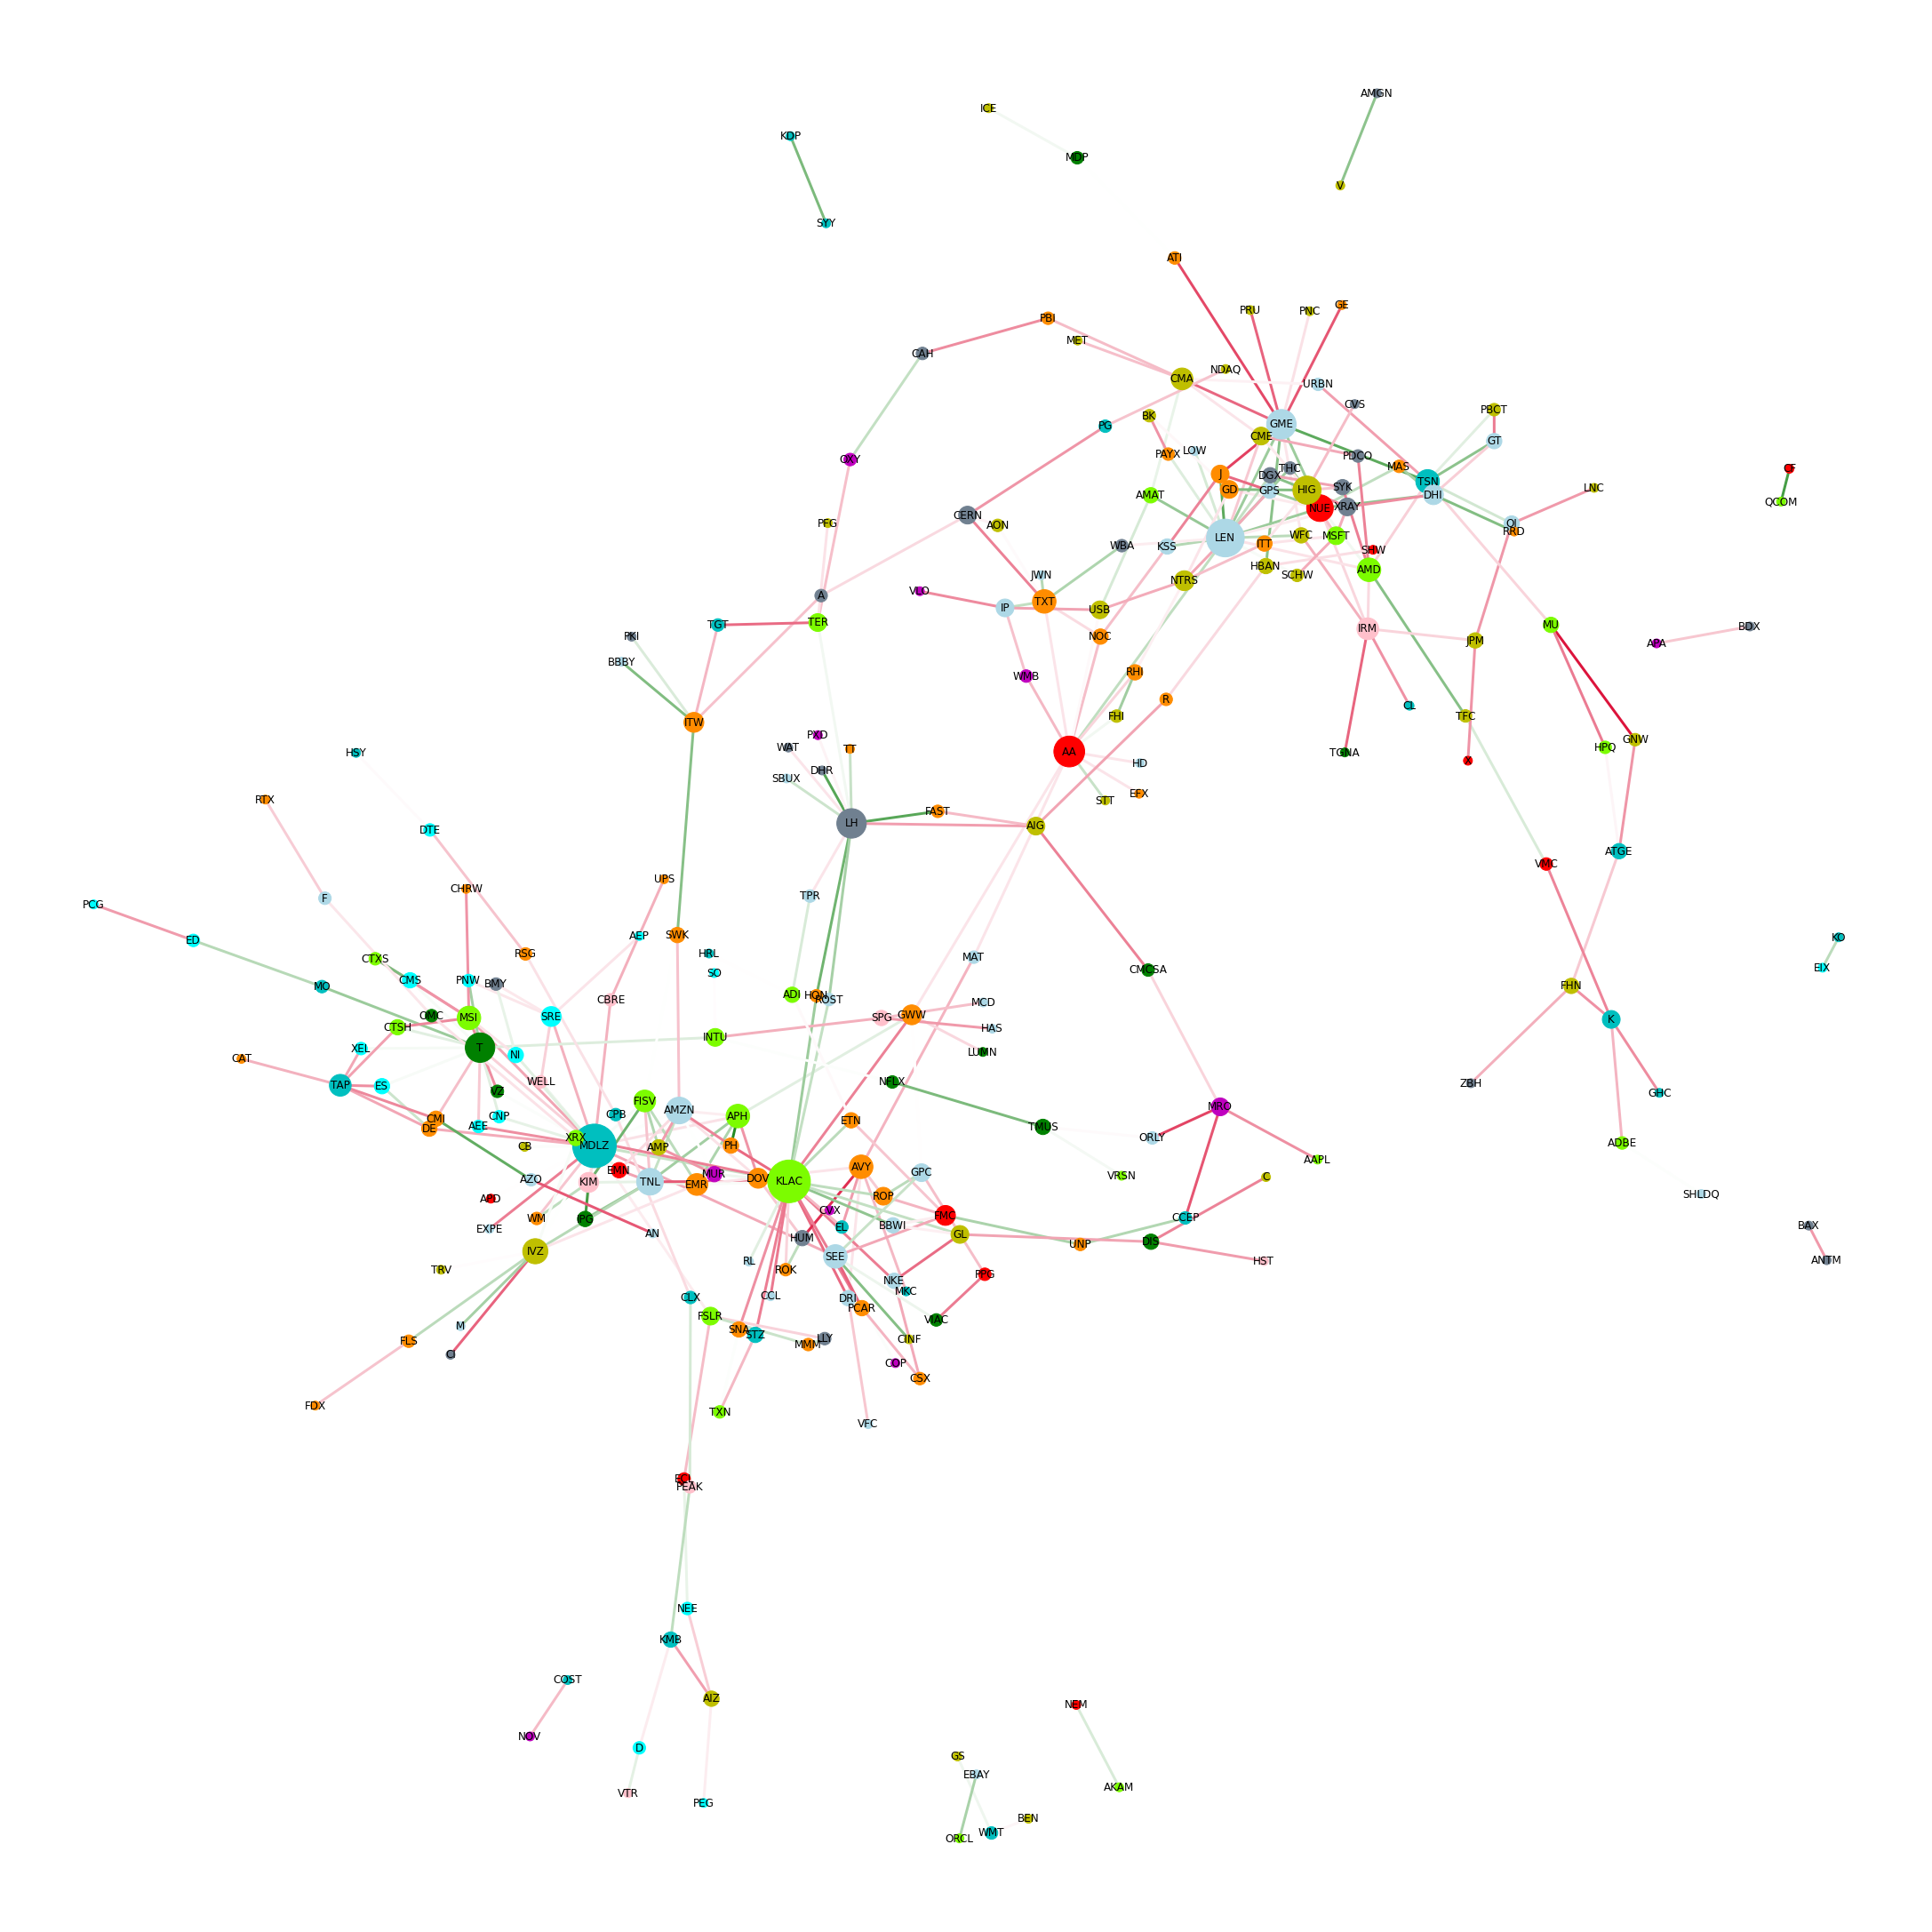

In [248]:
Gcoint = nx.Graph()
Gcoint.add_weighted_edges_from(list(edge_data[['leg1','leg2', 'Ret']].to_records(index=False)))
plt.figure(figsize=(30,30))
degree = dict(nx.degree(Gcoint))
cmap = matplotlib.colors.ListedColormap(['r','g','lightblue','c','m','y','slategrey','darkorange','pink','lawngreen','aqua'])
edges,weights = zip(*nx.get_edge_attributes(Gcoint,'weight').items())
nx.draw(Gcoint, pos = nx.spring_layout(Gcoint, k=0.6, iterations=60), with_labels=True, nodelist=degree.keys(), node_size=[v * 100 for v in degree.values()],
       node_color=pd.Categorical(comp_stats.loc[degree.keys()].Sector).codes, cmap=cmap,
       edgelist=edges, edge_color=weights, width = 3, edge_cmap=custom_cmap)

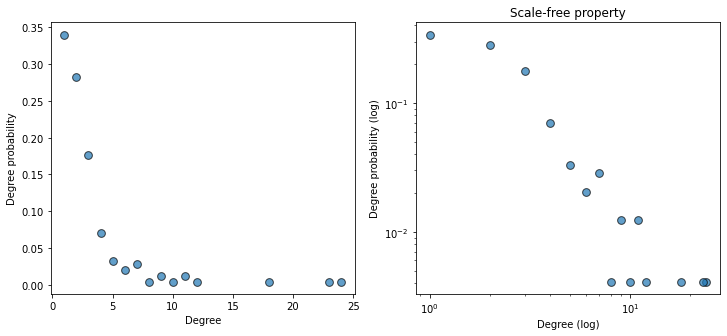

In [249]:
degree_count_coint = pd.Series(dict(Gcoint.degree).values(),index=dict(Gcoint.degree).keys(),name='Degree')

degreeProb = pd.Series(Counter(degree_count_coint).values(),index=Counter(degree_count_coint).keys())/sum(Counter(degree_count_coint).values())
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(degreeProb.index, degreeProb.values, s=60, alpha=0.7, edgecolors="k")
plt.xlabel('Degree')
plt.ylabel('Degree probability')
plt.subplot(1,2,2)

plt.scatter(degreeProb.index, degreeProb.values, s=60, alpha=0.7, edgecolors="k")
plt.title('Scale-free property')
plt.xlabel('Degree (log)')
plt.ylabel('Degree probability (log)')
plt.yscale("log")
plt.xscale("log");

In [250]:
degree_count2 = degree_count_coint.sort_values(ascending=False).reset_index(drop=True)
for i in range(0,10):
    print((i+1)/10,'  ',round((degree_count2/degree_count2.sum()).cumsum()[round(degree_count2.shape[0]*((i+1)/10))-1],3))

0.1    0.338
0.2    0.494
0.3    0.598
0.4    0.698
0.5    0.767
0.6    0.837
0.7    0.895
0.8    0.929
0.9    0.965
1.0    1.0


Text(0.5, 1.0, 'Limiting the number of times a company can be part of a pair to 3')

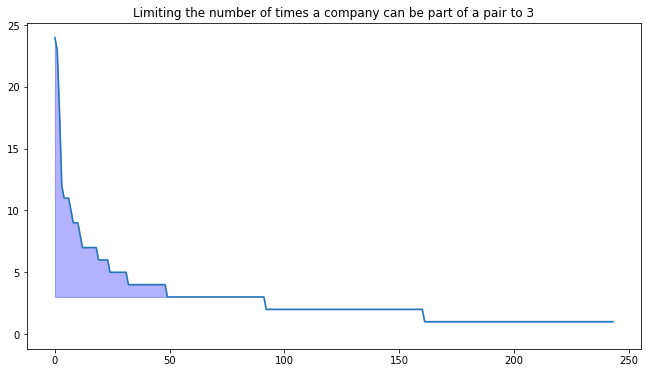

In [251]:
limit = 3

ticker_exp = degree_count2#/degree_count2.Count.sum()
ticker_exp.plot(figsize=(11,6));
plt.axhline(0, color='white');

limited_ticker_exp = []
for i in ticker_exp:
    if i > limit:
        limited_ticker_exp.append(limit)
    else:
        limited_ticker_exp.append(i)
        
plt.fill_between(ticker_exp.index, ticker_exp.values, limited_ticker_exp, color='b',
                 alpha=0.3);
plt.title(f'Limiting the number of times a company can be part of a pair to {limit}')

In [252]:
def get_lim_pairs(limit):

    max_p = limit
    max_count = {}
    limited_pairs = []
    for i in clean_prices:
        max_count[i] = 0

    for pair in pairsADF:
        if max_count[pair[0]] < max_p and max_count[pair[1]] < max_p:
            max_count[pair[0]] = max_count[pair[0]] + 1
            max_count[pair[1]] = max_count[pair[1]] + 1
            limited_pairs.append(pair)

    return limited_pairs

limited_pairs = get_lim_pairs(3)
print(len(limited_pairs))

192


In [253]:
ticker_lim_counts = list()
for i in range(1,degree_count2.max()+1):
    ticker_lim_counts.append(len(get_lim_pairs(i)))

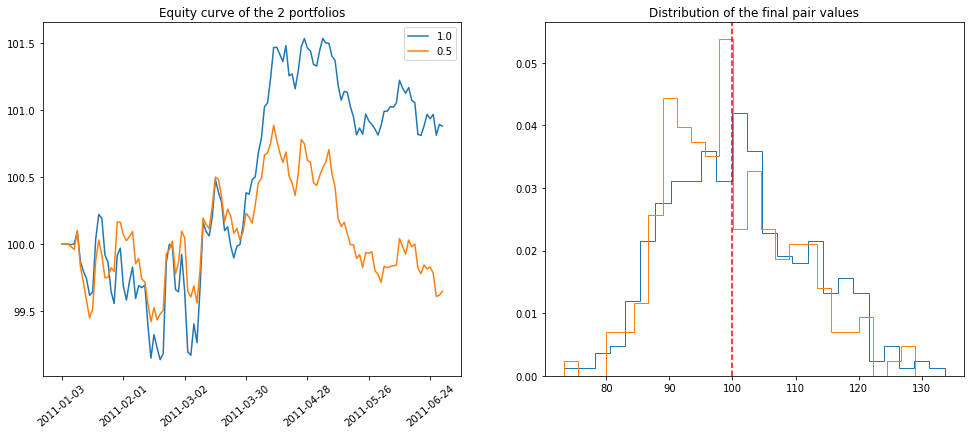

In [254]:
ratios = [1.0, 0.5]
start_lim_values = pd.DataFrame(columns=[i for i in ratios], index=clean_prices[tP1:tP2].index)

plt.figure(figsize=(16.5,6.5))
for i in ratios:
    lim = (np.argmin(abs(np.array(ticker_lim_counts)-len(pairsADF)*i))+1)
    pairs_lim_ADF = get_lim_pairs(lim)
    pair_NAVs = pd.DataFrame()
    for j in pairs_lim_ADF:
        port = portfolios[j]
        pair_NAVs = pd.concat([pair_NAVs, port], axis=1)
    #print(pair_NAVs.mean(axis=1).diff().dropna().std())
    #print(i,' - ', lim,' - ', len(pairs_lim_ADF), '\n')
    plt.subplot(1,2,1)
    plt.title(f'Equity curve of the {len(ratios)} portfolios')
    eq_val = pair_NAVs.mean(axis=1)
    eq_val.name = '{}'.format(i)
    start_lim_values.loc[clean_prices[tP1:tP2].index, i] = eq_val
    eq_val.plot(legend=True);
    plt.xticks(rotation=40)
    plt.subplot(1,2,2)
    plt.title('Distribution of the final pair values')
    plt.hist(pair_NAVs.iloc[-1],bins=25, density = True, linewidth=1,histtype='step');
plt.axvline(100, color='r', linestyle='--');

In [255]:
###Parameters
stock_index = 'NIKKEI'          #SNP, NIKKEI, BOVESPA
brkdwn = 'Sector'          #Sector/Industry
formation_period = 12        #in months, integers only
trading_period = 6          #in months, integers only

#Getting data
comp_stats=pd.read_csv("{}_comp_stats.csv".format(stock_index),index_col=0)
price_data=pd.read_csv("{}_prices2005-2021.csv".format(stock_index),index_col=0)
tickers=pd.read_csv("{}_tickers_2010-2020.csv".format(stock_index),index_col=0)

In [ ]:
ratios = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
allConsDates = ['2010-01-01']
i = 1
while int(allConsDates[-1][0:4])<2021:
    allConsDates.append(str((pd.Timestamp('2010-01-01')+pd.DateOffset(months=trading_period*i)).date()))
    i += 1
allConsDates.pop()
pairsData = pd.DataFrame(0,columns=['All','Selected','StoplossHit','Profitable','AvgTrade'],index=allConsDates)
start_lim_values = pd.DataFrame(columns=[i for i in ratios],
index=price_data[allConsDates[0]:str((pd.Timestamp(allConsDates[-1])+pd.DateOffset(months=trading_period)).date())].index)

for formation_date in allConsDates:
    formation_year = int(formation_date[0:4])
    fP1, fP2, tP1, tP2 = create_dates(formation_date)
    
    clean_prices = clean_data(fP1, tP2, formation_year, stock_index)
    stat_tics = get_stationary_tickers(clean_prices)
    clean_prices=clean_prices.drop(stat_tics, axis=1)
    brkdwn_list = get_ticker_brkdwn(brkdwn)
    
    allPosPairs = get_coint_pairs_ADF(brkdwn_list)
    pairsADF = list(allPosPairs.query('LS==1 & ADF < 0.05').sort_values(by='ADF').Pair)
    noPosP = allPosPairs.shape[0]
    
    portfolios = {}
    for c, pair in enumerate(pairsADF):
        pair = list(pair)
        results = regress2(clean_prices[pair[0]][fP1:fP2], clean_prices[pair[1]][fP1:fP2], _method_type_2="reduced major axis")
        spr = clean_prices[pair][fP1:tP2]@np.array([1,-1/results['slope']])
        spr_mean = spr[fP1:fP2].mean()
        spr_std = spr[fP1:fP2].std()
        norm_spr = (spr-spr_mean)/spr_std

        positions = pos_func(norm_spr[tP1:tP2],entries=np.array([2]),weights=np.array([1.0]),block=True,stoploss=5)
        port = equity_curve(positions, clean_prices[list(pair)][tP1:tP2], np.array([1,-1/results['slope']]),shorting_cost=0.0,commission=0.0,market_impact=0.0)
        portfolios[tuple(pair)] = port

    Gcoint = nx.Graph(pairsADF)
    degree_count2 = pd.DataFrame(Gcoint.degree,columns=['Ticker','Count'])
    degree_count2 = degree_count2.sort_values(by='Count',ascending=False).reset_index(drop=True)
    ticker_lim_counts = list()
    for i in range(1,degree_count2.Count.max()+1):
        ticker_lim_counts.append(len(get_lim_pairs(i)))
        
    plt.figure(figsize=(16.5,6.5))
    for i in ratios:
        lim = (np.argmin(abs(np.array(ticker_lim_counts)-len(pairsADF)*i))+1)
        pairs_lim_ADF = get_lim_pairs(lim)
        pair_NAVs = pd.DataFrame()
        for j in pairs_lim_ADF:
            port = portfolios[j]
            pair_NAVs = pd.concat([pair_NAVs, port], axis=1)

        plt.subplot(1,2,1)
        eq_val = pair_NAVs.mean(axis=1)
        eq_val.name = '{}'.format(i)
        start_lim_values.loc[clean_prices[tP1:tP2].index, i] = eq_val.pct_change()
        eq_val.plot(legend=True);
        plt.xticks(rotation=40)
        plt.subplot(1,2,2)
        plt.hist(pair_NAVs.iloc[-1],bins=25, density = True, linewidth=1,histtype='step');
    plt.axvline(100, color='r', linestyle='--');
    #plt.show();

There is no major impact on the return of the strategy with limiting the individual company exposure.


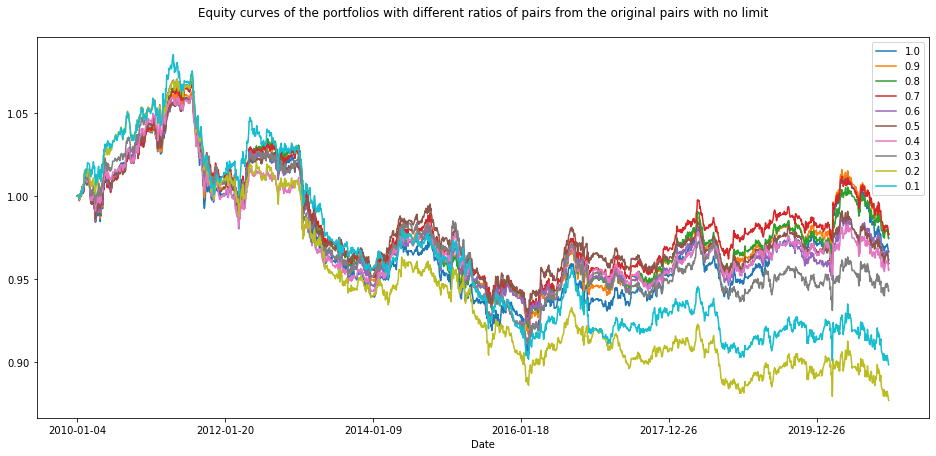

In [257]:
(start_lim_values.fillna(0)+1).cumprod().plot(figsize=(16,7));
plt.title('Equity curves of the portfolios with different ratios of pairs from the original pairs with no limit\n');
print('There is no major impact on the return of the strategy with limiting the individual company exposure.')

Only includeing 50% of all significantly cointegrated pairs with the proper
limit reduces the volatility of the strategy the most.


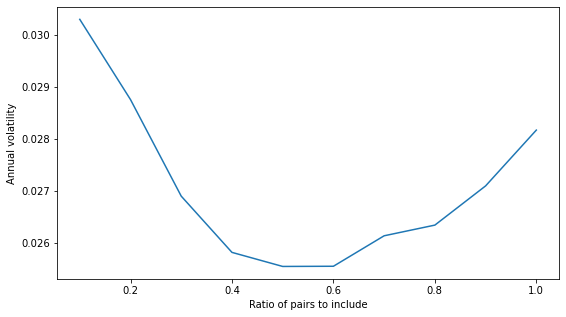

In [258]:
plt.figure(figsize=(9,5))
(np.std(start_lim_values.fillna(0))*(len(start_lim_values.fillna(0))/11)**.5).plot();
plt.ylabel('Annual volatility');
plt.xlabel('Ratio of pairs to include');
print('Only includeing 50% of all significantly cointegrated pairs with the proper\nlimit reduces the volatility of the strategy the most.')